In [2]:
import requests as rq
from pymongo import MongoClient
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression as LR 
from sklearn.model_selection import GridSearchCV
import warnings
import os

warnings.filterwarnings('ignore')

# Get the electricity demand data

In [3]:
end = '20190918T23-05'
start = '20130918T23-05'
key = '8a6315646d5695061696c71a041c42c0'
series_id = 'EBA.TEX-ALL.D.HL'
# series_id = 'EBA.NW-ALL.D.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [4]:
hourly_demand = data.json()['series'][0]['data']

In [5]:
electricity_demand = pd.DataFrame(hourly_demand, columns=['datetime','usage'])
electricity_demand.to_csv('electricity_data/electricity_demand.csv')

In [6]:
electricity_demand.head(1)

,datetime,usage
0,20190918T23-05,51199


In [7]:
electricity_demand.tail(1)

,datetime,usage
36934,20150701T01-05,37456


In [8]:
electricity_demand['datetime'] = pd.to_datetime(electricity_demand['datetime'], format='%Y%m%dT%H-%M')
electricity_demand['time'] = electricity_demand['datetime'].apply(lambda x:x.hour)
electricity_demand['month'] = electricity_demand['datetime'].apply(lambda x:x.month)
electricity_demand['weekday'] = electricity_demand['datetime'].apply(lambda x:x.weekday())
electricity_demand['year'] = electricity_demand['datetime'].apply(lambda x:x.year)
electricity_demand['day'] = electricity_demand['datetime'].apply(lambda x:x.day)

In [9]:
# Normalize the usage
electricity_demand['normalized_usage'] = preprocessing.MinMaxScaler().fit_transform(electricity_demand['usage'].values.reshape(-1,1))
electricity_demand.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage
0,2019-09-18 23:05:00,51199,23,9,2,2019,18,0.531163
1,2019-09-18 22:05:00,55171,22,9,2,2019,18,0.610970
2,2019-09-18 21:05:00,58070,21,9,2,2019,18,0.669218


In [10]:
electricity_demand.tail(2)

,datetime,usage,time,month,weekday,year,day,normalized_usage
36933,2015-07-01 02:05:00,35119,2,7,2,2015,1,0.208077
36934,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.255033


# Get the hourly weather data

In [11]:
weather_2013 = pd.read_csv('electricity_data/hourly_temperature_2013.csv')
weather_2015 = pd.read_csv('electricity_data/hourly_temperature_2015.csv')
weather_2016 = pd.read_csv('electricity_data/hourly_temperature_2016.csv')
weather = pd.concat([weather_2013, weather_2015, weather_2016])

# Other weather data.
# temp_dir = 'electricity_data/temperatures/'
# temp_dir = 'electricity_data/NW/'
stations = [72243012960, 72259003927, 72253012921]
# stations = []
# weather = pd.DataFrame()

'''
for file in os.listdir(temp_dir):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(temp_dir+file)
        stations.append(temp_df.head(1)['STATION'].values[0])
        weather = pd.concat([weather, temp_df], axis=0)
'''

"\nfor file in os.listdir(temp_dir):\n    if file.endswith('.csv'):\n        temp_df = pd.read_csv(temp_dir+file)\n        stations.append(temp_df.head(1)['STATION'].values[0])\n        weather = pd.concat([weather, temp_df], axis=0)\n"

In [12]:
print('Number of cites: {}'.format(len(stations)))

Number of cites: 3


In [13]:
weather.head(1)

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72243012960,2013-09-18T00:00:00,FM-12,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-11


In [14]:
# Many columns has very few useful rows. Collect only useful columns.
columns = weather.columns
num = len(weather)
num

281350

In [15]:
useful_columns = []
for column in columns:
    if sum(weather[column].isna()) > 30000:
        # There are more than 10000 nan
        print('{} is abondoned, containing {} NaN'.format(column, sum(weather[column].isna())))
    else:
        useful_columns.append(column)

AWND is abondoned, containing 281101 NaN
BackupDirection is abondoned, containing 281350 NaN
BackupDistance is abondoned, containing 281350 NaN
BackupDistanceUnit is abondoned, containing 281350 NaN
BackupElements is abondoned, containing 281350 NaN
BackupElevation is abondoned, containing 281350 NaN
BackupElevationUnit is abondoned, containing 281350 NaN
BackupEquipment is abondoned, containing 281350 NaN
BackupLatitude is abondoned, containing 281350 NaN
BackupLongitude is abondoned, containing 281350 NaN
BackupName is abondoned, containing 281350 NaN
CDSD is abondoned, containing 281101 NaN
CLDD is abondoned, containing 281101 NaN
DSNW is abondoned, containing 281101 NaN
DailyAverageDewPointTemperature is abondoned, containing 274149 NaN
DailyAverageDryBulbTemperature is abondoned, containing 273718 NaN
DailyAverageRelativeHumidity is abondoned, containing 274149 NaN
DailyAverageSeaLevelPressure is abondoned, containing 274163 NaN
DailyAverageStationPressure is abondoned, containing

In [16]:
weather = weather[useful_columns]

In [17]:
weather.head(1)

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlySkyConditions,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed,REM,REPORT_TYPE.1,SOURCE.1,WindEquipmentChangeDate
0,72243012960,2013-09-18T00:00:00,FM-12,4,75,77,94,NaN,29.87,9.94,76,000,0,SYN08072243 32566 60000 10250 20239 30115 4015...,FM-12,4,2009-06-11


In [18]:
def round_time(date_time):
    minute = date_time.minute
    if minute > 30:
        return date_time+timedelta(hours=1)
    else:
        return date_time

In [19]:
def parse_temperature(s):
    try:
        return float(s)
    except:
        try:
            return float(re.split('[a-z]+', s)[0])
        except:
            return np.nan

In [20]:
# Round the date info
weather['datetime'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather['date'] = weather['datetime'].apply(lambda date_time: round_time(date_time))
weather['time'] = weather['date'].apply(lambda x:x.hour)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['day'] = weather['date'].apply(lambda x:x.day)
# weather['weekday'] = weather['date'].apply(lambda x:x.weekday())
weather['year'] = weather['date'].apply(lambda x:x.year)
weather['HourlyDryBulbTemperature'] = weather['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))

In [21]:
# Get rid of nan and duplicated values
match_columns = ['year', 'month', 'day', 'time']
useful_columns = ['STATION', 'DATE', 'HourlyDryBulbTemperature', 'month', 'day', 'time', 'year']
weather = weather.loc[weather['HourlyDryBulbTemperature'].notna(),:]
weather = weather[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
weather.head(3)

,year,month,day,time,STATION,HourlyDryBulbTemperature
0,2013,9,18,0,72243012960,77.0
1,2013,9,18,0,72253012921,78.0
2,2013,9,18,0,72259003927,83.0


In [18]:
'''
houston = weather.loc[weather['STATION'] == 72243012960,:]
san_antonio = weather.loc[weather['STATION'] == 72259003927,:]
dallas = weather.loc[weather['STATION'] == 72253012921,:]
'''

# Merge the electricity data with the temprature data

In [22]:
'''
df_joined = electricity_demand.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
'''
bad_station = [72232403071] # Texas
# bad_station = [72063800224] # NW
df_joined = electricity_demand

for station in stations:
    if station not in bad_station:
        df_tmp = weather.loc[weather['STATION'] == station, :]
        if sum(df_tmp['HourlyDryBulbTemperature'].isna()) != 0:
            print(station)
        df_joined = df_joined.merge(df_tmp, how='inner', left_on=match_columns, right_on=match_columns)

In [23]:
'''
new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3', 'STATION_4', 'T_4',
       'STATION_5', 'T_5', 'STATION_6', 'T_6', 'STATION_7', 'T_7',
       'STATION_8', 'T_8', 'STATION_9', 'T_9', 'STATION_10', 'T_10',
       'STATION_11', 'T_11', 'STATION_12', 'T_12']
'''

new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3']

df_joined.columns = new_column_names
# df_joined = df_joined.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_Houston','HourlyDryBulbTemperature_y':'T_san_antonio','HourlyDryBulbTemperature':'T_dallas'})
# df_joined.to_csv('electricity_with_temperature.csv')
df_joined.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage,STATION_1,T_1,STATION_2,T_2,STATION_3,T_3
0,2019-09-18 23:05:00,51199,23,9,2,2019,18,0.531163,72243012960,78.0,72259003927,79.0,72253012921,85.0
1,2019-09-18 22:05:00,55171,22,9,2,2019,18,0.610970,72243012960,76.0,72259003927,79.0,72253012921,87.0
2,2019-09-18 21:05:00,58070,21,9,2,2019,18,0.669218,72243012960,78.0,72259003927,81.0,72253012921,89.0


In [24]:
# df_joined = pd.read_csv('electricity_with_temperature.csv',index_col=0)
df_joined = df_joined.sort_values(['datetime']).reset_index(drop=True)

In [25]:
pd.set_option('display.max_columns',100)
df_joined.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage,STATION_1,T_1,STATION_2,T_2,STATION_3,T_3
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.255033,72243012960,71.0,72259003927,77.0,72253012921,73.0
1,2015-07-01 02:05:00,35119,2,7,2,2015,1,0.208077,72243012960,71.0,72259003927,75.0,72253012921,74.0
2,2015-07-01 03:05:00,33638,3,7,2,2015,1,0.178320,72243012960,71.0,72259003927,76.0,72253012921,73.0


## Produce some sample data for the database

In [25]:
sample_for_app = df_joined.tail(336)
sample_for_app = sample_for_app[['datetime','usage','T_1','T_2','T_3']]
sample_for_app['temperatures'] = sample_for_app.apply(lambda row: ',,'.join([str(t) for t in row[['T_1','T_2','T_3']].values]), axis=1)

In [26]:
sample_for_app = sample_for_app[['datetime','usage','temperatures']]
sample_for_app['prediction'] = sample_for_app['usage']+1000
sample_for_app['net_gen'] = sample_for_app['usage']+1000
sample_for_app['region'] = 'TEX'

In [165]:
sample_for_app.head(3)
# sample_for_app.to_csv('sample', index=False)

,datetime,usage,temperatures,prediction,net_gen,region
36599,2019-09-05 00:05:00,49196,"77.0,,83.0,,81.0",50196,50196,TEX
36600,2019-09-05 01:05:00,45606,"77.0,,83.0,,79.0",46606,46606,TEX
36601,2019-09-05 02:05:00,43066,"77.0,,80.0,,78.0",44066,44066,TEX


In [166]:
MONGODB_HOST = 'localhost'
MONGODB_PORT = 27017
DBS_NAME = 'donorschoose'
COLLECTION_NAME = 'electricity_prediction'

connection = MongoClient(MONGODB_HOST, MONGODB_PORT)
collection = connection[DBS_NAME][COLLECTION_NAME]

In [51]:
for ind, row in sample_for_app.iterrows():
    collection.insert_one({'datetime': row['datetime'],
                           'usage':row['usage'],
                           'temperatures':row['temperatures'],
                           'prediction':row['prediction'],
                           'net_gen':row['net_gen'],
                           'region':row['region']})

In [3]:
new_item = {'datetime':datetime.strptime('2019-09-06 00:00:00', '%Y-%m-%d %H:%M:%S'),
                           'usage':60000,
                           'temperatures':"82,,33,,46",
                           'prediction':60000,
                           'net_gen':6000,
                           'region':'CAL'}

In [16]:
new_new_new = {'datetime':datetime.strptime('2019-09-06 00:01:00', '%Y-%m-%d %H:%M:%S'),
                           'usage':70000,
                           'temperatures':"81,,33,,46",
                           'prediction':70000,
                           'net_gen':70000,
                           'region':'NW'}

In [17]:
collection.insert_one(new_new_new)

In [158]:
'''
elec_regions = {'NW':{'WA','OR','NV','MT','ID','WY','UT','CO'},
               'CAL':{'CA'},
               'SW':{'AZ','NM'},
               'CENT':{'ND','SD','NE','KS','OK'},
               'CAR':{'NC','SC'},
               'FLA':{'FL'},
               'MIDA':{'OH','PA','WV','VA','MD','DE','NJ'},
               'MIDW':{'MN','IA','MO','AR','LA','WI','IL','MI','IN'},
               'NE':{'VT','NH','MA','CT','RI','ME'},
               'NY':{'NY'},
               'SE':{'MS','AL','GA'},
               'TEN':{'KY','TN'},
               'TEX':{'TX'}}

for k, v in elec_regions.items():
    if k not in ['TEX','CAL','NW']:
        new_item['datetime'] = new_item['datetime']+timedelta(minutes=10)
        new_item['usage'] = new_item['usage']+1000
        new_item['region'] = k
        collection.insert_one(new_item)
'''

"\nelec_regions = {'NW':{'WA','OR','NV','MT','ID','WY','UT','CO'},\n               'CAL':{'CA'},\n               'SW':{'AZ','NM'},\n               'CENT':{'ND','SD','NE','KS','OK'},\n               'CAR':{'NC','SC'},\n               'FLA':{'FL'},\n               'MIDA':{'OH','PA','WV','VA','MD','DE','NJ'},\n               'MIDW':{'MN','IA','MO','AR','LA','WI','IL','MI','IN'},\n               'NE':{'VT','NH','MA','CT','RI','ME'},\n               'NY':{'NY'},\n               'SE':{'MS','AL','GA'},\n               'TEN':{'KY','TN'},\n               'TEX':{'TX'}}\n\nfor k, v in elec_regions.items():\n    if k not in ['TEX','CAL','NW']:\n        new_item['datetime'] = new_item['datetime']+timedelta(minutes=10)\n        new_item['usage'] = new_item['usage']+1000\n        new_item['region'] = k\n        collection.insert_one(new_item)\n"

In [157]:
# collection.insert_one(new_item)

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 <a list of 11 Text yticklabel objects>)

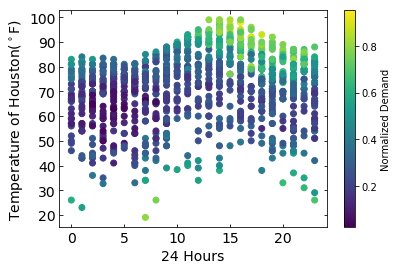

In [38]:
df_sample = df_joined.sample(1000)

"""
fig, ax = plt.subplots(figsize=(5,4))
sns.scatterplot(x='T_1', y='time', hue='normalized_usage', data=df_sample, ax=ax, legend=False)
# sns.scatterplot(x='T_1', y='usage', data=df_sample, ax=ax, legend=False)
ax.set_xlabel('Temperature of Houston($^\circ$F)', fontsize=14)
# ax.set_ylabel('24 Hours', fontsize=14)
# ax.set_ylabel('Megawatthours', fontsize=14)

# Adjust the display style
ax.tick_params(which = 'both',top=True,right=True,direction='in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
"""
plt.scatter(df_sample['time'], df_sample['T_1'], c=df_sample['normalized_usage'])
plt.colorbar(label="Normalized Demand")
ax = plt.gca()
ax.set_ylabel('Temperature of Houston($^\circ$F)', fontsize=14)
ax.set_xlabel('24 Hours', fontsize=14)
# Adjust the display style
ax.tick_params(which = 'both',top=True,right=True,direction='in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#sns.scatterplot(x='T_san_antonio', y='time', hue='normalized_usage', data=df_sample, ax=ax[1], legend=False)
#_ = sns.scatterplot(x='T_dallas', y='time', hue='normalized_usage', data=df_sample, ax=ax[2], legend=False)
# _ = sns.stripplot(x='weekday', y='time', hue='normalized_usage', data=df_sample, ax=ax[3])

(array([68., 72., 76., 80., 84., 88., 92.]),
 <a list of 7 Text yticklabel objects>)

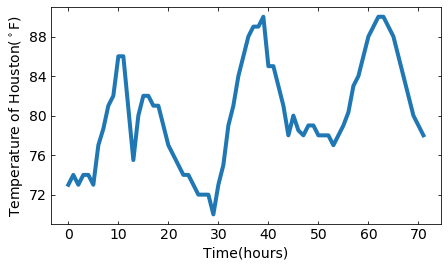

In [38]:
df_sample = df_joined.sample(1000)

fig, ax = plt.subplots(figsize=(7,4))
# sns.scatterplot(x='T_1', y='time', hue='normalized_usage', data=df_sample, ax=ax, legend=False)
# ax.plot(df_joined['T_1'].values[:72])
# ax.plot(df_joined['T_2'].values[:72])
ax.plot(df_joined['T_3'].values[:72], linewidth=4)
ax.set_ylabel('Temperature of Houston($^\circ$F)', fontsize=14)
ax.set_xlabel('Time(hours)', fontsize=14)

# Adjust the display style
ax.tick_params(which = 'both',top=True,right=True,direction='in')
ax.yaxis.set_major_locator(plt.MultipleLocator(4))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

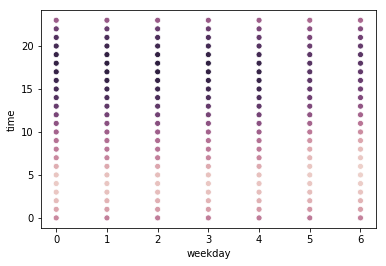

In [300]:
df_hourly_agg = df_joined[['time', 'weekday', 'usage']].groupby(['time', 'weekday'], as_index=False).mean()
_ = sns.scatterplot(x='weekday', y='time', hue='usage', data=df_hourly_agg, legend=False)

In [167]:
print('Total number of hours: {}'.format(len(df_joined)))
df_joined = df_joined.sort_values('datetime')

Total number of hours: 36935


In [194]:
# Split the train, validation, test dataset.
total_rows = len(df_joined)
split_num = 28175
valid_index = []
test_index = []
# we want the test and validation set to both cover an entire year. Therefore, they are taking alternative weeks.
for h in np.arange(split_num,total_rows,336):
    valid_index.extend(list(np.arange(h,h+168)))
    test_index.extend(list(np.arange(h+168,h+336)))

# remove indexes larger than 36935
while valid_index[-1] >= total_rows:
    valid_index.pop()

while test_index[-1] >= total_rows:
    test_index.pop()
    
valid_index = np.asarray(valid_index)
test_index = np.asarray(test_index)

fitting_index= 28175
train_index=36000 # 23175
# np.savetxt('valid_index.txt', valid_index)
# np.savetxt('test_index.txt', test_index)

In [195]:
def attenuate(X,Y,beta,column):
    # The first 24 hour will be used as warm up.
    X_new = (1-beta)*X[24:, column:].copy()
    # X_new += 0.9*X[23:-1,column:]+0.9*X[22:-2,column:]+0.9*X[21:-3,column:]+0.9*X[20:-4,column:]# +0.9*X[19:-5,column:]+0.9*X[18:-6,column:]
    # for h in np.arange(1, 6):
        # X_new = np.concatenate((X_new, X[24-h:-1*h,column:]), axis=1)
    for h in np.arange(1, 24):
        X_new += beta**h*(1-beta)*X[24-h:-1*h, column:]
    return np.concatenate((X[24:,:column], X_new), axis=1), Y[24:]

In [196]:
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_5','T_12']
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9','T_10','T_11','T_12','T_13']
# features = ['time', 'weekday', 'month', 'T_Houston', 'T_san_antonio', 'T_dallas'] # month may can be abondoned
features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3']
X = df_joined[features].values
Y = df_joined['usage'].values

def building_temp(beta):
    column = 3

    X_train = X[:train_index]# X[0:15706, :]
    Y_train = Y[:train_index]# Y[0:15706]
    # X_fitting = X[train_index:fitting_index]
    # Y_fitting = Y[train_index:fitting_index]
    X_train, Y_train = attenuate(X_train, Y_train, beta, column)
    # X_fitting, Y_fitting = attenuate(X_fitting, Y_fitting, beta, column)
    X_valid = X[train_index:]# X[valid_index]# X[15706:20941,:]
    Y_valid = Y[train_index:]#Y[valid_index]# Y[15706:20941]
    # X_test = X[test_index]
    # Y_test = Y[test_index]
    X_valid, Y_valid = attenuate(X_valid, Y_valid, beta, column)
    # X_test, Y_test = attenuate(X_test, Y_test, beta, column)

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)
    # X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)
    
    # For X_valid and X_test we also need to get rid of every monday.
    new_valid_index = []
    # new_test_index = []

    for h in np.arange(0, len(X_valid), 168):
        new_valid_index.extend(list(np.arange(h,h+144)))
        # new_test_index.extend(list(np.arange(h,h+144)))

    # remove indexes larger than 36935
    while new_valid_index[-1] >= len(X_valid):
        new_valid_index.pop()

    # while new_test_index[-1] >= len(X_test):
        # new_test_index.pop()

    new_valid_index = np.asarray(new_valid_index)
    # new_test_index = np.asarray(new_test_index)
    X_valid = X_valid[new_valid_index]
    Y_valid = Y_valid[new_valid_index]
    # X_test = X_test[new_test_index]
    # Y_test = Y_test[new_test_index]
    
    return X_train, Y_train, X_valid, Y_valid

In [49]:
'''
# One-hot encode 'time' and 'weekday'
def one_hot(raw):
    time = raw[:,1].reshape(-1).astype(int)
    raw = np.concatenate((raw[:,2:], raw[:,:1]), axis=1)
    nb_classes = 24
    time_one_hot = np.eye(nb_classes)[time]
    new = np.concatenate((time_one_hot, raw), axis=1)
    return new
'''

"\n# One-hot encode 'time' and 'weekday'\ndef one_hot(raw):\n    time = raw[:,1].reshape(-1).astype(int)\n    raw = np.concatenate((raw[:,2:], raw[:,:1]), axis=1)\n    nb_classes = 24\n    time_one_hot = np.eye(nb_classes)[time]\n    new = np.concatenate((time_one_hot, raw), axis=1)\n    return new\n"

In [50]:
'''
# Try increasing the weights of the points with high temperatures.
multiples = 100
X_over = []# oversampled X.
Y_over = []
for x,y in zip(X_train,Y_train):
    if x[2] > 90 or x[3] > 90 or x[4] > 90:
        for i in np.arange(multiples):
            X_over.append(list(x))
            Y_over.append(y)
    else:
        X_over.append(list(x))
        Y_over.append(y)
'''

'\n# Try increasing the weights of the points with high temperatures.\nmultiples = 100\nX_over = []# oversampled X.\nY_over = []\nfor x,y in zip(X_train,Y_train):\n    if x[2] > 90 or x[3] > 90 or x[4] > 90:\n        for i in np.arange(multiples):\n            X_over.append(list(x))\n            Y_over.append(y)\n    else:\n        X_over.append(list(x))\n        Y_over.append(y)\n'

In [197]:
from sklearn import base
from sklearn.metrics import make_scorer

class elec_forcast(base.BaseEstimator):
    
    def __init__(self, n_estimators=700, min_samples_split=4, min_samples_leaf=2, max_features=3, random_state=10):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.rf = RF(n_estimators=self.n_estimators, min_samples_split=self.min_samples_split, \
                    min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, \
                    random_state=self.random_state)
        
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators,
                "min_samples_split":self.min_samples_split,
                "min_samples_leaf": self.min_samples_leaf,
                "max_features": self.max_features,
                "random_state": self.random_state}
        
    def fit(self, X, y):
        self.rf.fit(X,y)
        return self
        
    def predict(self, X, y):
        Y_pred = self.rf.predict(X)
        Y_pred = LR().fit(Y_pred.reshape(-1,1), y.reshape(-1,1)).predict(Y_pred.reshape(-1,1))        
        return Y_pred       
        
    def score(self, X, Y_true):
        Y_pred = self.predict(X, Y_true)
        return r2_score(Y_true, Y_pred)

In [199]:
# Perform grid search to look for the best parameters
grid = {'n_estimators': [200],
       'min_samples_split': [2],
       'min_samples_leaf': [1],
       'max_features': [1,2,3,4],# [0.3,0.5,0.7],
       'random_state': [10]}

max_r2 = -np.inf
best_params = None
best_beta = None
bar = tqdm_notebook(total=2*2*3)

for beta in [0.82,0.83,0.84]:
    X_train, Y_train, X_valid, Y_valid = building_temp(beta)
    train_end = len(X_train)
    valid_end = train_end+len(Y_valid)
    train_ind = np.arange(train_end)
    valid_ind = np.arange(train_end, valid_end)
    # Concatenate the train and validation set.
    X_total = np.concatenate((X_train, X_valid), axis=0)
    Y_total = np.concatenate((Y_train, Y_valid))
    search = GridSearchCV(elec_forcast(), grid, cv=[(train_ind, valid_ind)], n_jobs=4, verbose=10)
    search.fit(X_total, Y_total)
    # The best parameters.
    r2 = search.best_score_
    p = search.best_params_
    if max_r2 < r2:
        max_r2 = r2
        best_params = p
        best_beta = beta
    print('Best R2 score {} for {}.'.format(r2, beta))
    
    bar.update(3*2**4)
bar.close()
        
print('The maximum R2 score is: {} \n The best parameters are: {} \n The best beta is: {}'.format(max_r2, best_params, best_beta))

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min finished


Best R2 score 0.9746116998854685 for 0.82.
Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


Best R2 score 0.9741694969028989 for 0.83.
Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.9min finished


Best R2 score 0.9738119566524676 for 0.84.

The maximum R2 score is: 0.9746116998854685 
 The best parameters are: {'min_samples_leaf': 1, 'random_state': 10, 'max_features': 1, 'n_estimators': 200, 'min_samples_split': 2} 
 The best beta is: 0.82


In [176]:
print(best_params,best_beta)

{'min_samples_leaf': 1, 'random_state': 10, 'max_features': 0.1, 'n_estimators': 200, 'min_samples_split': 2} 0.83


Current best parameters: {'random_state': 1, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 1, 'beta': 0.85} 0.9771
{'random_state': 1, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 600, 'min_samples_leaf': 1, 'beta': 0.83} 0.9773
{'random_state': 1, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 550, 'min_samples_leaf': 1, 'beta':0.84} 0.9774
{'random_state': 1, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 450, 'min_samples_leaf': 1, 'beta': 0.84} 0.9774

In [610]:
print(best_params,best_beta)

{'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 700,
 'random_state': 1}

In [177]:
X_train, Y_train, X_valid, Y_valid = building_temp(0.84)

In [178]:
best_params = {'n_estimators': 200, 'random_state': 10, 'min_samples_leaf': 1, 'max_features': 0.1, 'min_samples_split': 2}
RF_model = RF(**best_params).fit(X_train, Y_train)
# my_estimator = elec_forcast(**best_params).fit(X_train, Y_train)

In [179]:
Y_valid_pred = RF_model.predict(X_valid)
LR_model = LR().fit(Y_valid_pred.reshape(-1,1), Y_valid.reshape(-1,1))
print('coefficient and intercept of linear model {}, {}'.format(LR_model.coef_, LR_model.intercept_))

coefficient and intercept of linear model [[1.07223412]], [-910.23447923]


In [180]:
# X_valid = one_hot(X_valid)
Y_predict = RF_model.predict(X_valid)
print('The R2 score is: {}'.format(r2_score(Y_valid, Y_predict*1.07223412-910)))

The R2 score is: 0.9812774983166579


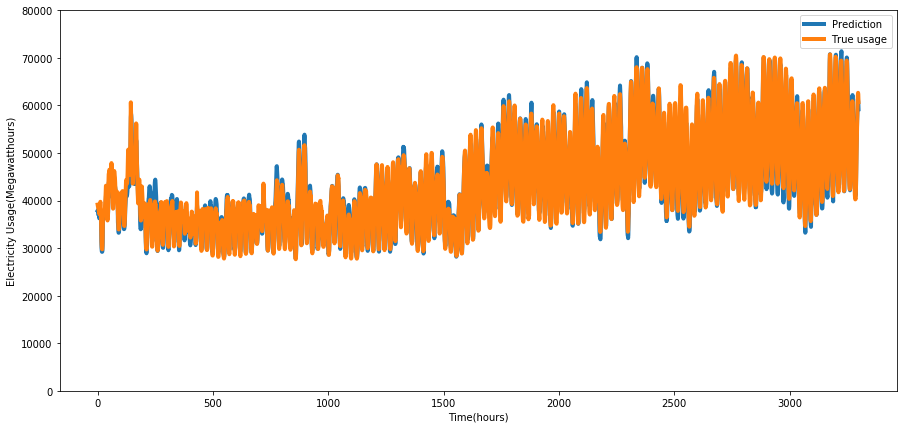

In [182]:
X_visualize = X_valid[0:3300]
Y_visualize = Y_valid[0:3300]
plt.figure(figsize=(15,7))
Y_predict = RF_model.predict(X_visualize)
# Y_predict = my_estimator.predict(X_visualize, Y_visualize)

plt.plot(Y_predict*1.07223412-910, linewidth=4)
plt.plot(Y_visualize, linewidth=4)
# plt.plot(X_visualize[:,3]*100)
plt.xlabel('Time(hours)')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['Prediction','True usage'])
plt.ylim([0,80000])
plt.show()

In [55]:
# Calculate the linear transform directly
Y_pred = RF_model.predict(X_valid)
LR_model = LR().fit(Y_pred.reshape(-1,1), Y_valid.reshape(-1,1))
print('coefficient and intercept of linear model {}, {}'.format(LR_model.coef_, LR_model.intercept_))

coefficient and intercept of linear model [[1.1148148]], [-3872.42545633]


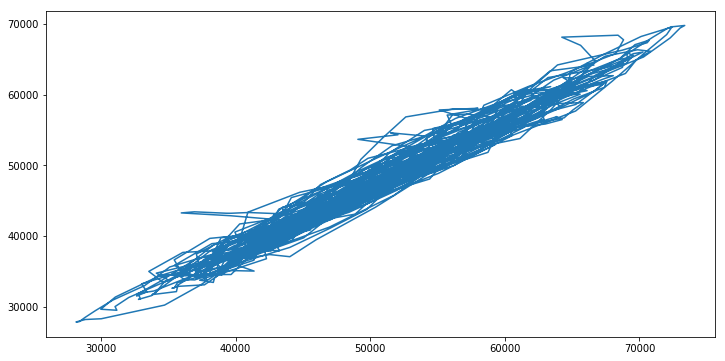

In [305]:
plt.figure(figsize=(12,6))
_ = plt.plot(Y_predict, Y_valid)

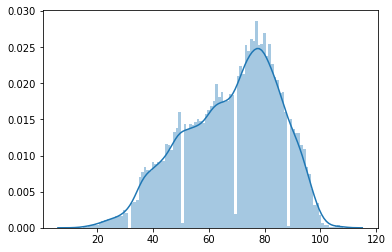

In [116]:
# Try assign more weights to high temperature
# Histogram of temperature
_ = sns.distplot(X[:,3], bins=100) # Interesting, what are these suddenly diappeared temperature?

In [117]:
# The temperature for the outliers.
X[16406:16431, 3]

array([68., 69., 74., 76., 77., 80., 82., 81., 91., 93., 94., 93., 90.,
       86., 82., 79., 73., 68., 65., 65., 65., 65., 66., 67., 67.])

In [118]:
# The next day should be cold.
X[16431:16456, 3] # So the next day is indeed cold but there seems a sudden boost of the temperature in the first day.

array([66. , 67. , 68. , 67. , 67. , 69. , 72. , 76. , 81. , 80. , 76. ,
       72. , 68. , 64. , 62. , 57. , 54.5, 53. , 53. , 53. , 53. , 53. ,
       54. , 54. , 54. ])

In [119]:
# The previous day.
X[16385:16406, 3]

array([62.        , 63.        , 62.        , 64.        , 67.        ,
       70.        , 72.        , 72.        , 68.        , 63.        ,
       61.33333333, 59.        , 57.        , 56.25      , 55.        ,
       54.        , 56.66666667, 58.        , 60.        , 62.        ,
       64.5       ])

It doesn't seem like a problem of under-fitting.

Check I didn't make a mistake on the time and temperature

In [135]:
df_joined.loc[16406:16431,:]

,datetime,usage,time,month,weekday,year,day,normalized_usage,T_Houston,T_san_antonio,T_dallas
16406,2017-11-03 01:05:00,35535,1,11,4,2017,3,0.204106,75.500000,68.0,74.000000
16407,2017-11-03 00:05:00,38185,0,11,4,2017,3,0.258189,76.000000,69.0,74.000000
16408,2017-11-02 23:05:00,41482,23,11,3,2017,2,0.325476,76.000000,74.0,73.000000
16409,2017-11-02 22:05:00,44388,22,11,3,2017,2,0.384783,77.000000,76.0,72.000000
16410,2017-11-02 21:05:00,46465,21,11,3,2017,2,0.427172,78.000000,77.0,77.000000
16411,2017-11-02 20:05:00,47663,20,11,3,2017,2,0.451621,78.000000,80.0,75.000000
16412,2017-11-02 19:05:00,47727,19,11,3,2017,2,0.452928,80.000000,82.0,76.000000
16413,2017-11-02 18:05:00,48875,18,11,3,2017,2,0.476357,82.000000,81.0,79.000000
16414,2017-11-02 17:05:00,49346,17,11,3,2017,2,0.485969,84.000000,91.0,84.000000
16415,2017-11-02 16:05:00,48482,16,11,3,2017,2,0.468336,87.000000,93.0,85.000000


In [160]:
X[16415]

array([16.,  3., 87., 93., 85.])

In [162]:
Y[16415]

48482

Not really

In [159]:
# That Saturday.
df_joined.loc[16406-48:16431-48,:]

,datetime,usage,time,month,weekday,year,day,normalized_usage,T_Houston,T_san_antonio,T_dallas
16358,2017-11-05 01:05:00,35487,1,11,6,2017,5,0.203127,74.000000,76.00,70.000000
16359,2017-11-05 00:05:00,37675,0,11,6,2017,5,0.247781,74.000000,76.00,71.000000
16360,2017-11-04 23:05:00,39986,23,11,5,2017,4,0.294945,74.000000,77.00,71.000000
16361,2017-11-04 22:05:00,42045,22,11,5,2017,4,0.336966,75.000000,77.00,74.000000
16362,2017-11-04 21:05:00,43676,21,11,5,2017,4,0.370252,76.000000,78.00,72.000000
16363,2017-11-04 20:05:00,45121,20,11,5,2017,4,0.399743,77.000000,79.00,75.000000
16364,2017-11-04 19:05:00,45604,19,11,5,2017,4,0.409600,79.000000,81.00,79.000000
16365,2017-11-04 18:05:00,46811,18,11,5,2017,4,0.434233,81.000000,82.00,80.000000
16366,2017-11-04 17:05:00,47343,17,11,5,2017,4,0.445091,83.000000,85.00,83.000000
16367,2017-11-04 16:05:00,46857,16,11,5,2017,4,0.435172,85.000000,89.00,84.000000


In [184]:
# Try analyze the data with Houston in [87,89] San Antonio in [93,95] Dallas in [83,85]

X_in_range = X[(X[:,2] > 85) & (X[:,2] < 90) & (X[:,3] > 90) & (X[:,3] < 95) & (X[:,4] > 80) & (X[:,4] < 85)]
Y_in_range = Y[(X[:,2] > 85) & (X[:,2] < 90) & (X[:,3] > 90) & (X[:,3] < 95) & (X[:,4] > 80) & (X[:,4] < 85)]

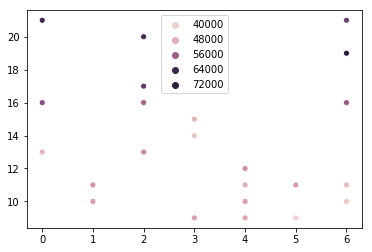

In [185]:
_ = sns.scatterplot(x=X_in_range[:,1], y=X_in_range[:,0], hue=Y_in_range)

In [186]:
Y_in_range[X_in_range[:,1] == 2]

array([63832, 61092, 60316, 51361, 63226, 55173])

In [148]:
X_in_range = X_train[(X_train[:,2] > 85) & (X_train[:,2] < 90) & (X_train[:,3] > 90) & (X_train[:,3] < 95) & (X_train[:,4] > 80) & (X_train[:,4] < 85)]
Y_in_range = Y_train[(X_train[:,2] > 85) & (X_train[:,2] < 90) & (X_train[:,3] > 90) & (X_train[:,3] < 95) & (X_train[:,4] > 80) & (X_train[:,4] < 85)]

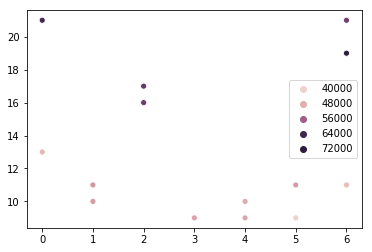

In [145]:
_ = sns.scatterplot(x=X_in_range[:,1], y=X_in_range[:,0], hue=Y_in_range)

Text(0, 0.5, 'Electricity Demand(Megawatthours)')

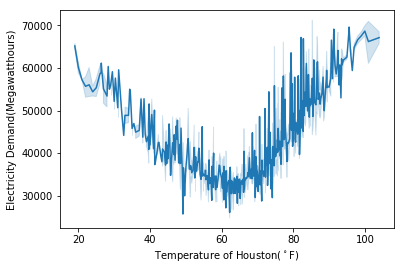

In [119]:
ax = sns.lineplot(x=X[:,3], y=Y)
ax.set_xlabel('Temperature of Houston($^\circ$F)')
ax.set_ylabel('Electricity Demand(Megawatthours)')

# Analyze the Present Data

In [183]:
# Load the electricity data from Sep 17 to Sep 24
elec_present = pd.read_csv('electricity_data/texas_sep_18.csv')

In [184]:
elec_present.head(1)

,Region Code,Timestamp (Hour Ending),Demand (MWh),Demand Forecast (MWh),Net Generation (MWh),Total Interchange (MWh)
0,TEX,9/16/2019 12 AM CDT,47548,47905.0,47125.0,-424.0


In [185]:
elec_present.columns

Index(['Region Code', 'Timestamp (Hour Ending)', 'Demand (MWh)',
       'Demand Forecast (MWh)', 'Net Generation (MWh)',
       'Total Interchange (MWh)'],
      dtype='object')

In [186]:
elec_present = elec_present.loc[:,['Timestamp (Hour Ending)', 'Demand (MWh)', 'Demand Forecast (MWh)']]

In [187]:
elec_present = elec_present.rename(columns={'Timestamp (Hour Ending)':'datetime','Demand (MWh)':'usage','Demand Forecast (MWh)':'prediction'})

In [188]:
elec_present['datetime'] = pd.to_datetime(elec_present['datetime'], format='%m/%d/%Y %I %p CDT')
elec_present['time'] = elec_present['datetime'].apply(lambda x:x.hour)
elec_present['month'] = elec_present['datetime'].apply(lambda x:x.month)
elec_present['weekday'] = elec_present['datetime'].apply(lambda x:x.weekday())
elec_present['year'] = elec_present['datetime'].apply(lambda x:x.year)
elec_present['day'] = elec_present['datetime'].apply(lambda x:x.day)

In [189]:
# Load the weather data
weather_sep_18 = pd.read_csv('electricity_data/weather_sep_18.csv')
# Round the date info
weather_sep_18['datetime'] = pd.to_datetime(weather_sep_18['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather_sep_18['date'] = weather_sep_18['datetime'].apply(lambda date_time: round_time(date_time))
weather_sep_18['time'] = weather_sep_18['date'].apply(lambda x:x.hour)
weather_sep_18['month'] = weather_sep_18['date'].apply(lambda x:x.month)
weather_sep_18['day'] = weather_sep_18['date'].apply(lambda x:x.day)
# weather_sep_18['weekday'] = weather_sep_18['date'].apply(lambda x:x.weekday())
weather_sep_18['year'] = weather_sep_18['date'].apply(lambda x:x.year)
weather_sep_18['HourlyDryBulbTemperature'] = weather_sep_18['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))
weather_sep_18 = weather_sep_18.loc[weather_sep_18['HourlyDryBulbTemperature'].notna(),:]
weather_sep_18 = weather_sep_18[useful_columns]
weather_sep_18 = weather_sep_18[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
houston = weather_sep_18.loc[weather_sep_18['STATION'] == 72243012960,:]
san_antonio = weather_sep_18.loc[weather_sep_18['STATION'] == 72259003927,:]
dallas = weather_sep_18.loc[weather_sep_18['STATION'] == 72253012921,:]
df_sep_18 = elec_present.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_1','HourlyDryBulbTemperature_y':'T_2','HourlyDryBulbTemperature':'T_3'})
df_sep_18 = df_sep_18.sort_values('datetime')

In [190]:
df_sep_18.head(1)

,datetime,usage,prediction,time,month,weekday,year,day,T_1,T_2,T_3
0,2019-09-16,47548,47905.0,0,9,0,2019,16,76.0,83.0,79.0


In [191]:
beta = 0.83
X_present = df_sep_18[features].values
Y_present = df_sep_18['usage'].values
X_present, Y_present = attenuate(X_present, Y_present, beta, 3)
Y_web_pred = df_sep_18['prediction'].values[25:]

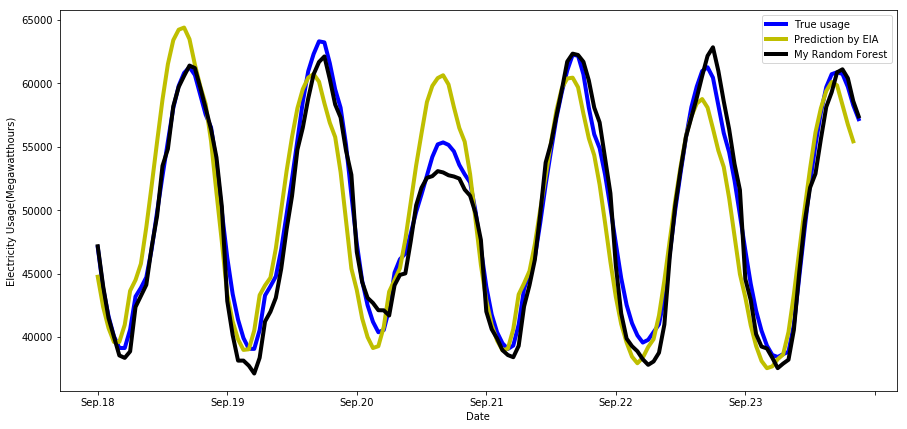

In [193]:
from matplotlib.ticker import MultipleLocator

Y_pred = RF_model.predict(X_present)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(Y_present, 'b', linewidth=4)
plt.plot(Y_web_pred, 'y', linewidth=4)
plt.plot(Y_pred*1.07223412-910, 'black', linewidth=4)
plt.xlabel('Date')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['True usage', 'Prediction by EIA', 'My Random Forest'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', 'Sep.18', 'Sep.19', 'Sep.20', 'Sep.21', 'Sep.22', 'Sep.23'])
plt.show()

## Time Series Model

In [11]:
electricity_demand_sorted = electricity_demand.sort_values(['datetime']).reset_index(drop=True)

In [12]:
electricity_demand_sorted.head(3)

,datetime,usage,time,month,weekday,year,day
0,2015-07-01 01:05:00,37456,1,7,2,2015,1
1,2015-07-01 02:05:00,35119,2,7,2,2015,1
2,2015-07-01 03:05:00,33638,3,7,2,2015,1


In [25]:
# Make sure there is no missed hours.
wrong_intervals = []

for ind in np.arange(len(electricity_demand_sorted)-1):
    if electricity_demand_sorted.iloc[ind]['datetime']+timedelta(hours=1) != electricity_demand_sorted.iloc[ind+1]['datetime']:
        wrong_intervals.append(ind)

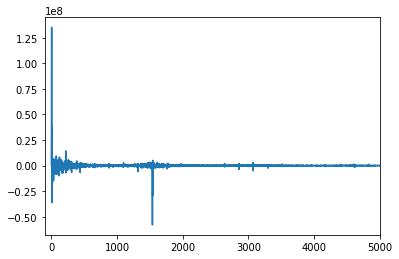

In [47]:
mean_removed = electricity_demand_sorted['usage'].values - np.mean(electricity_demand_sorted['usage'].values)
fft = np.fft.fft(mean_removed)
plt.plot(fft)
_ = plt.xlim([-100,5000])

In [64]:
# Peak for the daily cycle
daily_peak = np.where((fft < -3e7) | (fft > 1e7))[0]
print('the preak corresponding to the daily cycle: {}'.format(daily_peak))

the preak corresponding to the daily cycle: [    1     2     3     4     7     8     9   220  1539 35396 36715 36926
 36927 36928 36931 36932 36933 36934]


3 corresponding to something around 1.4 year
4 corresponding to something around 1.05 year
8 corresponding to something around 0.53 year ->
9 corresponding to something around 0.46 year -> These two should be corresponding to the half a year period (check whether there are pseudo periods)
220 corresponding to the weekly period (not that strong compared to the daily peak)
1539 corresponding to the daily period

## Check to see how many harmonics we should include

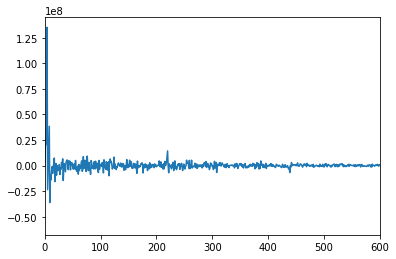

In [71]:
plt.plot(fft)
_ = plt.xlim([0,600])

Let's fit a periodic model first.<br>
three harmonics for the yearly cycle and two harmonics for the weekly and daily cycle.<br>
Try the first three years as the training set first

In [72]:
df_for_periodic_model = electricity_demand_sorted.copy()

In [101]:
def diff_in_hours(x):
    # This function returns the number of hours from 2015-07-01 01:05:00
    minutes = (x-datetime(2015, 7, 1, 1, 5, 0)).total_seconds()/60
    if minutes % 60 > 30:
        return minutes/60 + 1
    else:
        return minutes/60
    
df_for_periodic_model['hours'] = electricity_demand_sorted['datetime'].apply(lambda x: diff_in_hours(x))

In [102]:
df_for_periodic_model.head(3)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,yearly_3_sin,yearly_3_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2015-07-01 02:05:00,35119,2,7,2,2015,1,1.0,0.000717,1.000000,...,0.002150,0.999998,0.037391,0.999301,0.074730,0.997204,0.258819,0.965926,0.500000,0.866025
2,2015-07-01 03:05:00,33638,3,7,2,2015,1,2.0,0.001434,0.999999,...,0.004301,0.999991,0.074730,0.997204,0.149042,0.988831,0.500000,0.866025,0.866025,0.500000


In [240]:
# Construct the sin and cos columns.
def trig(func, period, x):
    # This function returns a sin or x value of x.
    return func(2*np.pi*x/period)

# Yearly period.
df_for_periodic_model['yearly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_for_periodic_model['yearly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_for_periodic_model['yearly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_for_periodic_model['yearly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_for_periodic_model['yearly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_for_periodic_model['yearly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_for_periodic_model['weekly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_for_periodic_model['weekly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_for_periodic_model['weekly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_for_periodic_model['weekly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_for_periodic_model['dayly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24, x))
df_for_periodic_model['dayly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24, x))
df_for_periodic_model['dayly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_for_periodic_model['dayly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_for_periodic_model['dayly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_for_periodic_model['dayly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_for_periodic_model['dayly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_for_periodic_model['dayly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/4, x))

In [104]:
df_for_periodic_model.head(3)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,yearly_3_sin,yearly_3_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2015-07-01 02:05:00,35119,2,7,2,2015,1,1.0,0.000717,1.000000,...,0.002150,0.999998,0.037391,0.999301,0.074730,0.997204,0.258819,0.965926,0.500000,0.866025
2,2015-07-01 03:05:00,33638,3,7,2,2015,1,2.0,0.001434,0.999999,...,0.004301,0.999991,0.074730,0.997204,0.149042,0.988831,0.500000,0.866025,0.866025,0.500000


There is a slowly varying trend which should be handled first using a ridge regression.

In [105]:
df_for_periodic_model.tail(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,yearly_3_sin,yearly_3_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos
36934,2019-09-18 23:05:00,51199,23,9,2,2019,18,36982.0,0.980846,0.194783,...,-0.831992,-0.554788,0.733052,0.680173,0.997204,-0.07473,-0.5,0.866025,-0.866025,0.5


In [107]:
# Produce the x^2 and X^3 term for the ridge regressor

df_for_periodic_model['scaled_hours'] = df_for_periodic_model['hours']/100
df_for_periodic_model['scaled_hours_squared'] = df_for_periodic_model['scaled_hours']**2
df_for_periodic_model['scaled_hours_cubic'] = df_for_periodic_model['scaled_hours']**3

In [157]:
columns_x = ['scaled_hours', 'scaled_hours_squared', 'scaled_hours_cubic']
X = df_for_periodic_model[columns_x].values
y = df_for_periodic_model['usage'].values/1e4

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# search = GridSearchCV(Line, params, cv=5, n_jobs=4, verbose=10)
# _ = search.fit(X,y)
linear_trend = LinearRegression().fit(X[:,0].reshape(-1,1), y)

In [192]:
print(linear_trend.coef_, linear_trend.intercept_)

[0.00162474] 3.8928100300940485


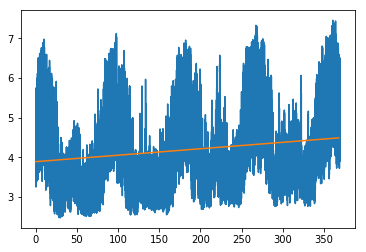

In [193]:
plt.plot(X[:,0],y)
X_sample = np.arange(int(X[-1,0]))
_ = plt.plot(X_sample, linear_trend.predict(X_sample.reshape(-1,1)))

In [194]:
linear_trend.c

array([0.00162474])

In [195]:
def remove_trend(row):
    return row['usage']-(row['scaled_hours']*linear_trend.coef_[0]+linear_trend.intercept_)*1e4

df_for_periodic_model['usage_trend_removed'] = df_for_periodic_model[['usage','scaled_hours']].apply(lambda row: remove_trend(row), axis=1)

# Split the train, test and validation set

df_train = df_for_periodic_model.iloc[:train_index]
df_valid = df_for_periodic_model.iloc[valid_index]
df_test = df_for_periodic_model.iloc[test_index]

In [196]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301


In [241]:
columns_x = []
for column in df_train.columns:
    if column.endswith('sin') or column.endswith('cos'):
        columns_x.append(column)

In [242]:
X = df_train[columns_x].values
y = df_train['usage_trend_removed'].values

period_model = LinearRegression().fit(X,y)

In [243]:
period_model.coef_

array([ 3822.75713454,  6415.70887752,  2830.03767946,  2983.67559318,
        -150.44983634,  -636.28208157,   762.90873997,  1112.36053659,
        -632.34873725,  -230.61807329, -5891.27455544, -4097.12080555,
       -1057.06125805,  -704.06067565])

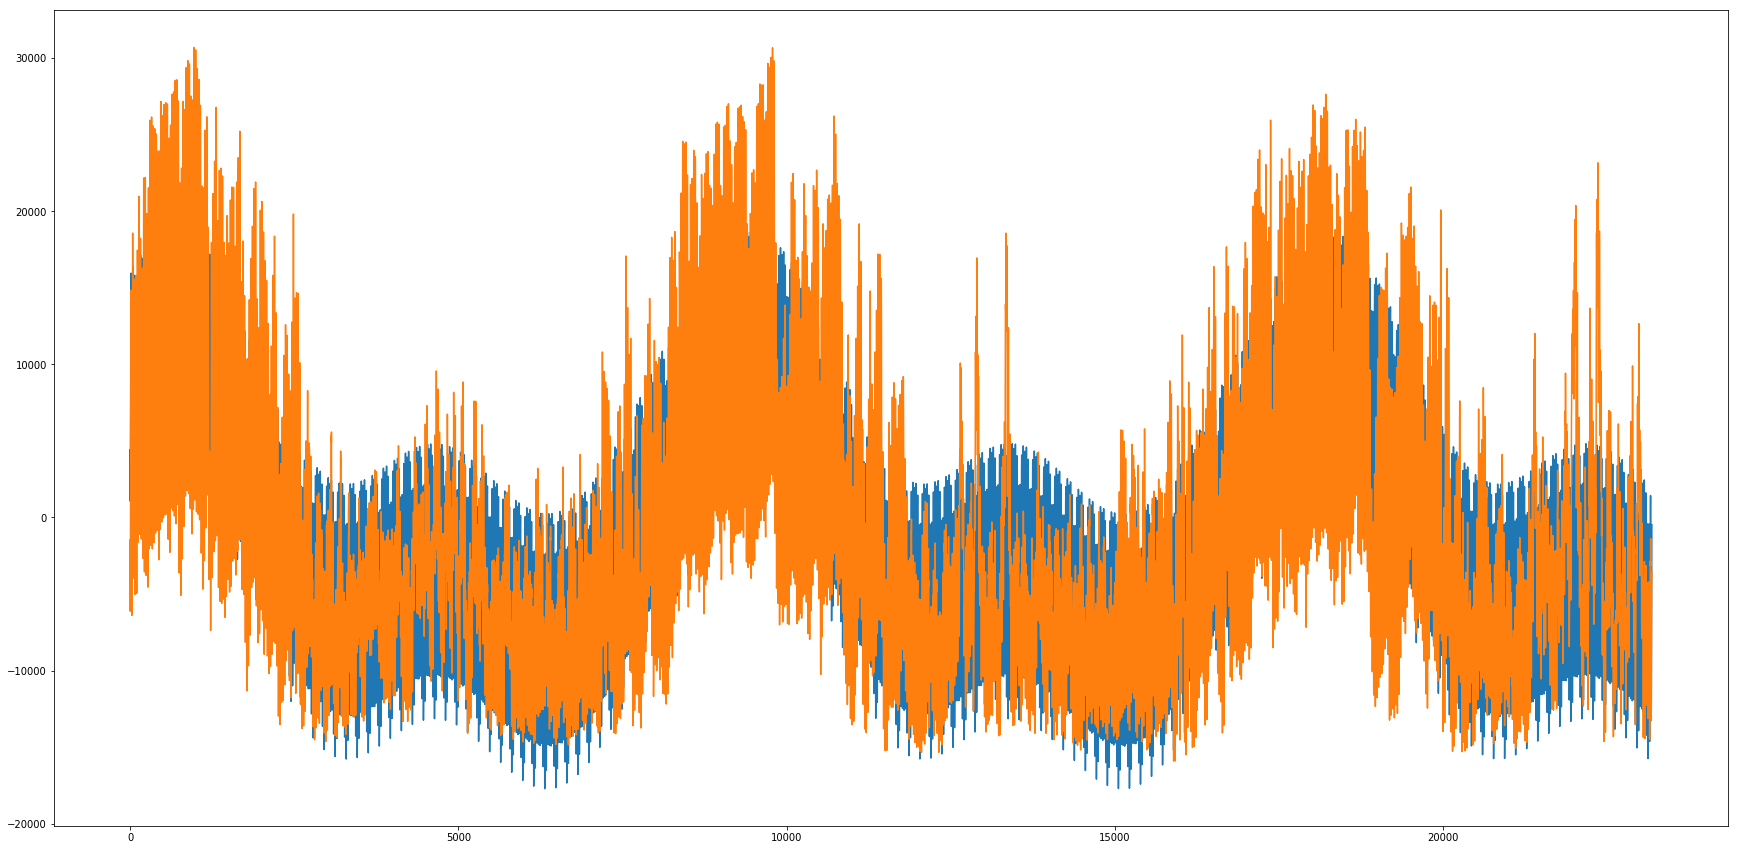

In [244]:
from sklearn.metrics import r2_score

# Plot the prediction for the train data
#df_valid = df_valid.reset_index(drop=True)
samples_X = df_train.loc[:, columns_x].values
samples_Y = df_train.loc[:, 'usage_trend_removed'].values
train_pred = period_model.predict(samples_X)

plt.subplots(figsize=(30,15))
plt.plot(train_pred)
_ = plt.plot(samples_Y)

# r2_score(samples_Y, pred_Y)

r2_score: 0.7224138831072557


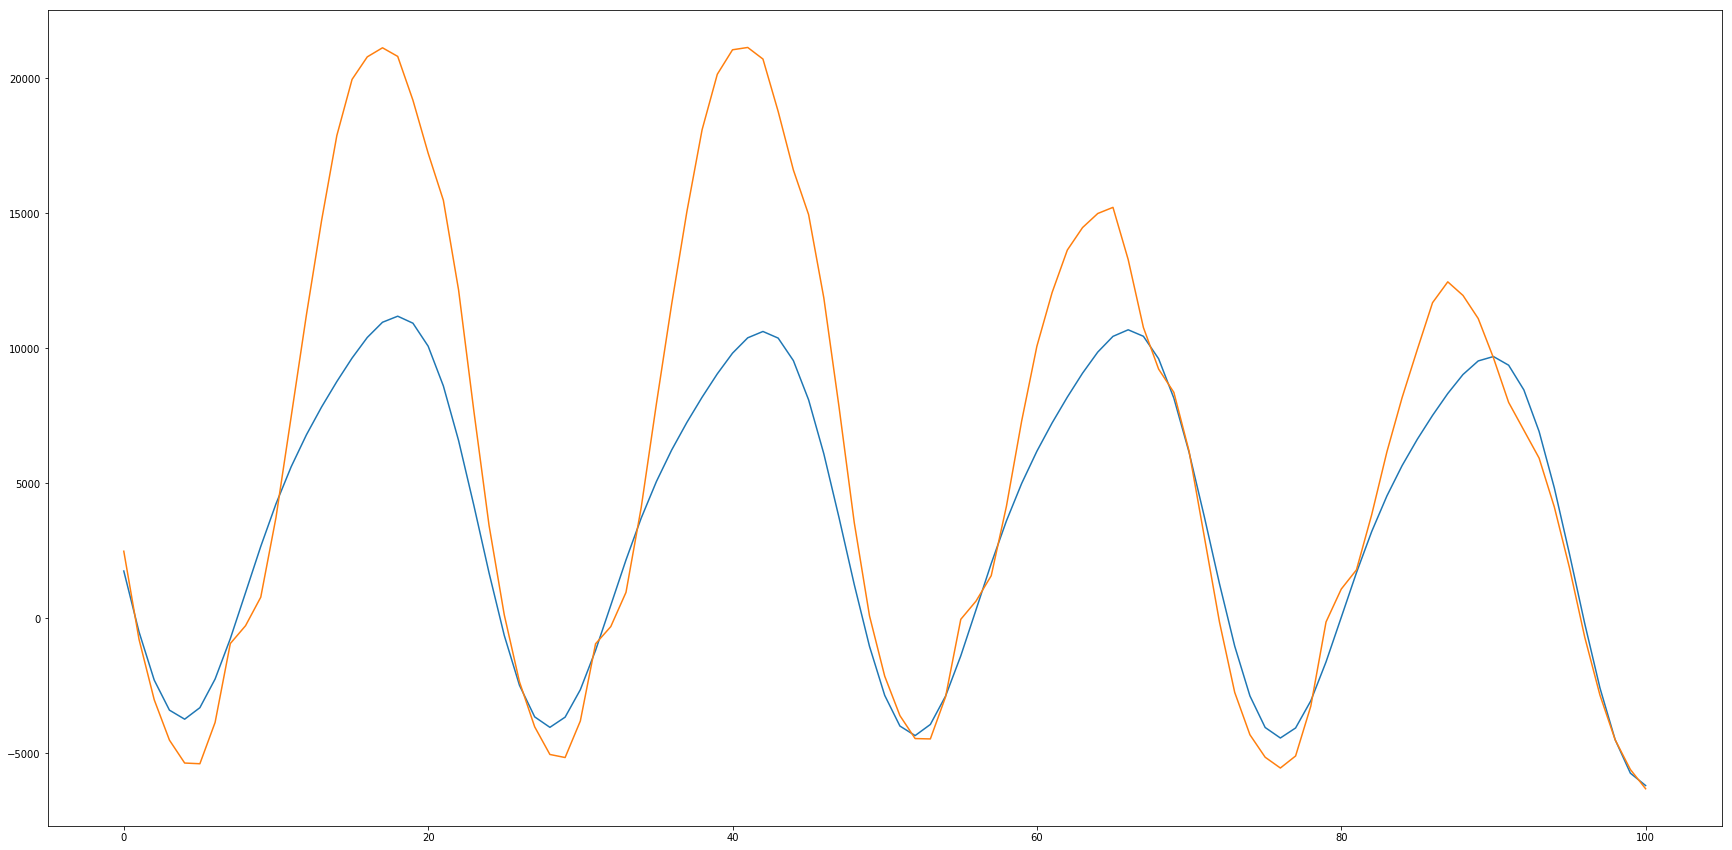

In [245]:
# plot the prediction for the validation data.

df_valid = df_valid.reset_index(drop=True)
samples_X = df_valid.loc[:100, columns_x].values
samples_Y = df_valid.loc[:100, 'usage_trend_removed'].values
pred_Y = period_model.predict(samples_X)

plt.subplots(figsize=(30,15))
plt.plot(pred_Y)
plt.plot(samples_Y)

print('r2_score: {}'.format(r2_score(samples_Y, pred_Y)))

Try auto correlation and partial autocorrelation in the residual to make new discovery.

In [246]:
df_train.loc[:, 'pred'] = train_pred.reshape(-1)

df_train.loc[:, 'residual'] = df_train.loc[:, 'usage_trend_removed'] - df_train.loc[:, 'pred']

/Users/minjielu/anaconda3/envs/Renaissance/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


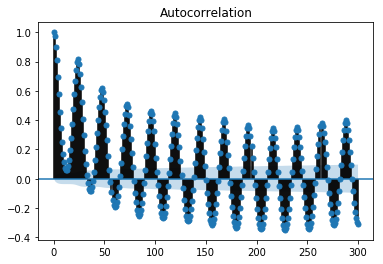

In [247]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(df_train['residual'],lags=300)

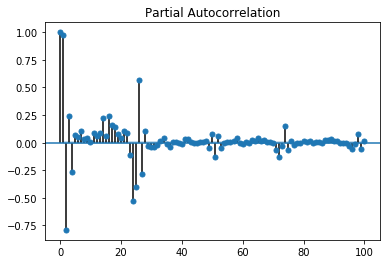

In [264]:
_ = plot_pacf(df_train['residual'],lags=100)

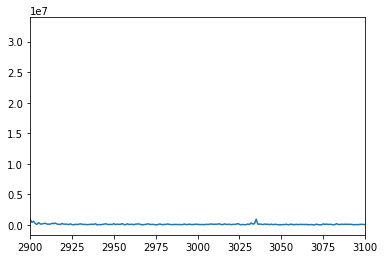

In [279]:
residual_fft = np.absolute(np.fft.fft(df_train['residual']))
plt.plot(residual_fft)
_ = plt.xlim([2900,3100])

In [270]:
len(df_train)

23175

In [275]:
23175/2/3.14*0.95

3505.7722929936303

In [274]:
np.arctan(1.4)

0.9505468408120751

In [277]:
23175/3030/24

0.3186881188118812

(-1, 70)

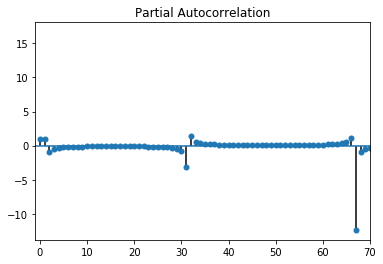

In [284]:
X = np.sin(np.arange(0,30,0.1))
_ = plot_pacf(X)
plt.xlim([-1,70])

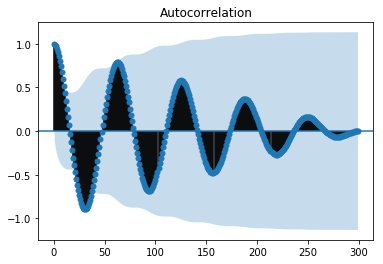

In [286]:
_ = plot_acf(X)

In [463]:
from statsmodels.tsa.stattools import ccf

In [486]:
ccf_1 = ccf(df_train['residual'], df_joined.iloc[:train_index]['T_Houston'])

(-0.2, 0.2)

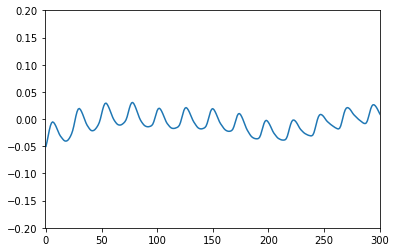

In [493]:
plt.plot(ccf_1)
plt.xlim([-1,300])
plt.ylim([-0.2,0.2])

In [482]:
5000/24

208.33333333333334

In [490]:
df_joined.head(1)

,datetime,usage,time,month,weekday,year,day,T_Houston,T_san_antonio,T_dallas
36934,2015-07-01 01:05:00,37456,1,7,2,2015,1,71.0,77.0,73.0


In [491]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,residual,pred
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301,-5889.020771,4416.92047
